In [1]:
!tar -zxvf TCL_IDC.tar.gz 

x TCL_IDC/
x TCL_IDC/c26a5_00286/
x TCL_IDC/c26a5_00105/
x TCL_IDC/.DS_Store
x TCL_IDC/c26a5_00144/
x TCL_IDC/c26a5_00233/
x TCL_IDC/c26a5_00039/
x TCL_IDC/c26a5_00295/
x TCL_IDC/c26a5_00278/
x TCL_IDC/c26a5_00240/
x TCL_IDC/c26a5_00225/
x TCL_IDC/c26a5_00223/
x TCL_IDC/c26a5_00107/
x TCL_IDC/c26a5_00067/
x TCL_IDC/c26a5_00004/
x TCL_IDC/c26a5_00296/
x TCL_IDC/c26a5_00059/
x TCL_IDC/c26a5_00059/.DS_Store
x TCL_IDC/c26a5_00059/checkpoint
x TCL_IDC/c26a5_00296/.DS_Store
x TCL_IDC/c26a5_00296/checkpoint
x TCL_IDC/c26a5_00004/.DS_Store
x TCL_IDC/c26a5_00004/checkpoint
x TCL_IDC/c26a5_00067/.DS_Store
x TCL_IDC/c26a5_00067/checkpoint
x TCL_IDC/c26a5_00107/.DS_Store
x TCL_IDC/c26a5_00107/checkpoint
x TCL_IDC/c26a5_00223/.DS_Store
x TCL_IDC/c26a5_00223/checkpoint
x TCL_IDC/c26a5_00225/.DS_Store
x TCL_IDC/c26a5_00225/checkpoint
x TCL_IDC/c26a5_00240/.DS_Store
x TCL_IDC/c26a5_00240/checkpoint
x TCL_IDC/c26a5_00278/.DS_Store
x TCL_IDC/c26a5_00278/checkpoint
x TCL_IDC/c26a5_00295/.DS_Store
x TCL_I

In [2]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sys
sys.path.append('../')
sys.path.append('../model/sourcemodel')
import pickle

from util import AverageMeter, accuracy

def load_data(dir):
    with open(dir, 'rb') as f:
        data = pickle.load(f)
    f.close()
    return data

_partition_random_state = [0,1,2]
T_SIZE = 219388
data_fractions = [400/T_SIZE, 600/T_SIZE, 800/T_SIZE]

In [3]:
# testing
def validate_aux(val_loader, model, criterion, print_freq):
    """One epoch validation for aux type classifier"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        labels = []
        outputs = []
        logit_out = []
        for idx, (input, target) in enumerate(val_loader):
            
            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # append result:
            labels.append(target.cpu().numpy())
            outputs.append(np.argmax(output.cpu().numpy(), axis=1))
            logit_out.append(output.cpu().numpy())

            # measure accuracy and record loss
            acc1, _ = accuracy(output, target, topk=(1, 2))

            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))

            if idx % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                    .format(
                    idx, len(val_loader), batch_time=batch_time, loss=losses,
                    top1=top1, ))

        print(' * Acc@1 {top1.avg:.3f}'
              .format(top1=top1))

        labels = np.hstack(labels)
        outputs = np.hstack(outputs)
        logit_out = np.vstack(logit_out)

    # return top1.avg, losses.avg, f1.avg, auc_meter.avg, auc_meter.cls_auc, ece.ece_, ece.acc, ece.conf
    return {'ACC': top1.avg.item(),
            'logit': logit_out,
            }


In [4]:
from data_manager.IDC import get_dataloader
def load_idc(random_state=0):
    root = '/Users/juanwenwang/datasets/Breast Histopathology Images'
    path = root + '/' + 'Breast_histopathplogy_data.csv'
    bs = 32
    cur = 1
    ss = 1.0
    n_wok = 3
    n_split = 5
    noise = None
    mean = 0
    var = 0
    amount = 0

    dataloader = get_dataloader(root, path, bs, ss, cur, n_wok, n_split, noise, mean, var, amount,
                                         random_state=random_state)
    train_loader, val_loader, test_loader = dataloader.get_data_loader()

    return train_loader, val_loader, test_loader

In [5]:
df = pd.read_csv('./result.csv')
df

,Unnamed: 0,ACC,trial_id,Learning Method,Training Size,partition_random_state,currerent_fold,data_percentage
0,0,81.242989,c26a5_00004,TCL (Conv),800,0,1,0.003647
1,1,83.187889,c26a5_00004,TCL (Conv),800,0,1,0.003647
2,2,83.949829,c26a5_00004,TCL (Conv),800,0,1,0.003647
3,3,82.303581,c26a5_00004,TCL (Conv),800,0,1,0.003647
4,4,83.681763,c26a5_00004,TCL (Conv),800,0,1,0.003647
...,...,...,...,...,...,...,...,...
1245,1245,84.453239,c26a5_00296,TCL (Conv),600,0,4,0.002735
1246,1246,82.704018,c26a5_00296,TCL (Conv),600,0,4,0.002735
1247,1247,80.626602,c26a5_00296,TCL (Conv),600,0,4,0.002735
1248,1248,80.721336,c26a5_00296,TCL (Conv),600,0,4,0.002735


In [6]:
result_id_aux = []

for cfold in range(5):
    for lm in ['TE2E (Conv)', 'TCL (Conv)']:
            for d in df.data_percentage.unique(): # datapercentage
                try:
                    r = df.loc[(df['currerent_fold'] == cfold)
                                        &(df['Learning Method'] == lm)
                               &(df['data_percentage'] == d)]
                    result_id_aux.append(r['ACC'].idxmax())
                except Exception as e: 
                    continue


aux = df.loc[result_id_aux].copy()

max_result = aux
max_result['Training Size'] = max_result['data_percentage'].apply(lambda x: int(T_SIZE * x))
max_result['Classifier'] = 'Aux'
max_result = max_result.replace('Aux', 'Auxiliary')

max_ = max_result.groupby(['Classifier','data_percentage'
                           , 'partition_random_state', 'Learning Method']).max()
max_

Unnamed: 0  \
Classifier data_percentage partition_random_state Learning Method               
Auxiliary  0.001823        0                      TCL (Conv)             1025   
                                                  TE2E (Conv)             515   
                           1                      TCL (Conv)              238   
                                                  TE2E (Conv)             737   
                           2                      TE2E (Conv)             306   
           0.002735        0                      TCL (Conv)             1114   
                                                  TE2E (Conv)             268   
                           1                      TCL (Conv)              540   
                                                  TE2E (Conv)            1003   
                           2                      TE2E (Conv)            1072   
           0.003647        0                      TCL (Conv)               84   
                                                  TE2E (Conv)             587   
                           1                      TCL (Conv)              796   
                                                  TE2E (Conv)             965   
                           2                      TE2E (Conv)             452   

                                                                         ACC  \
Classifier data_percentage partition_random_state Learning Method              
Auxiliary  0.001823        0                      TCL (Conv)       85.948631   
                                                  TE2E (Conv)      83.613914   
                           1                      TCL (Conv)       84.513420   
                                                  TE2E (Conv)      85.783867   
                           2                      TE2E (Conv)      86.184517   
           0.002735        0                      TCL (Conv)       85.833664   
                                                  TE2E (Conv)      85.277023   
                           1                      TCL (Conv)       86.035881   
                                                  TE2E (Conv)      86.654587   
                           2                      TE2E (Conv)      86.390450   
           0.003647        0                      TCL (Conv)       86.413368   
                                                  TE2E (Conv)      85.410744   
                           1                      TCL (Conv)       86.699615   
                                                  TE2E (Conv)      83.567688   
                           2                      TE2E (Conv)      86.191109   

                                                                      trial_id  \
Classifier data_percentage partition_random_state Learning Method                
Auxiliary  0.001823        0                      TCL (Conv)       c26a5_00144   
                                                  TE2E (Conv)      c26a5_00295   
                           1                      TCL (Conv)       c26a5_00240   
                                                  TE2E (Conv)      c26a5_00067   
                           2                      TE2E (Conv)      c26a5_00223   
           0.002735        0                      TCL (Conv)       c26a5_00296   
                                                  TE2E (Conv)      c26a5_00105   
                           1                      TCL (Conv)       c26a5_00278   
                                                  TE2E (Conv)      c26a5_00225   
                           2                      TE2E (Conv)      c26a5_00039   
           0.003647        0                      TCL (Conv)       c26a5_00004   
                                                  TE2E (Conv)      c26a5_00059   
                           1                      TCL (Conv)       c26a5_00286   
                                                  TE2E (Conv)      c26a5_00107   
                

In [7]:
max_.trial_id

Classifier  data_percentage  partition_random_state  Learning Method
Auxiliary   0.001823         0                       TCL (Conv)         c26a5_00144
                                                     TE2E (Conv)        c26a5_00295
                             1                       TCL (Conv)         c26a5_00240
                                                     TE2E (Conv)        c26a5_00067
                             2                       TE2E (Conv)        c26a5_00223
            0.002735         0                       TCL (Conv)         c26a5_00296
                                                     TE2E (Conv)        c26a5_00105
                             1                       TCL (Conv)         c26a5_00278
                                                     TE2E (Conv)        c26a5_00225
                             2                       TE2E (Conv)        c26a5_00039
            0.003647         0                       TCL (Conv)         c26a5_00004
       

In [8]:
# getting test result
from sklearn.metrics import confusion_matrix

path = './TCL_IDC'
def get_model_score(trial_id):
    output, logit, score = 0, 0, 0
    for i in os.listdir(path):
        if trial_id in i:
            ckpt = os.path.join(path, i, 'checkpoint')
#                     print(torch.load(ckpt, map_location='cpu'))
            output = torch.load(ckpt, map_location='cpu')['model_state_dict']
            logit = torch.load(ckpt, map_location='cpu')['predict_logit']
            score = torch.load(ckpt, map_location='cpu')['score']
                        
    return output, logit, score

def get_test_acc_logit(df, trial_id):
    trial_config = df.loc[df.trial_id == trial_id].iloc[0]
    
    _, logit, score = get_model_score(trial_id)
    return {'logit':logit, 'ACC':score}


In [9]:
# compute combined classifier performance

acc_combined = []
classifier = []
data_fraction = []
test_partition = []

for i in ['Auxiliary']:
    for j in df.data_percentage.unique():
        for p in df.partition_random_state.unique(): # random state of test partition
            try:
                trials = max_.loc[(i,j,p)]
                assert len(trials) == 2 # need TCL and TE2E to combine
            except:
                continue
                
            # load testing set
            test_loader = load_idc(random_state=p)[2]
            label_test = test_loader.dataset.df_data.target.to_numpy()

            trial_id = list(trials.trial_id)
            trial_1 = get_test_acc_logit(df, trial_id[0])
            trial_2 = get_test_acc_logit(df, trial_id[1])

            # result for trial 1
            logit_trial_1 = trial_1['logit']

            # result for trial 2
            logit_trial_2 = trial_2['logit']

            # combined activations
            combined = (logit_trial_1 + logit_trial_2) / 2

            # calculate acc
            acc = 100* np.sum(np.argmax(combined, axis=1) == label_test)/len(label_test)

            # combined classfiers
            acc_combined.append(acc)
            classifier.append(i)
            data_fraction.append(j)
            test_partition = [p]
        
df_combined = pd.DataFrame({'Classifier':classifier
                            , 'data_percentage':data_fraction
                            , 'Testing_ACC':acc_combined,
                           'Testing Partition':p})
df_combined['Training Size'] = df_combined['data_percentage'].apply(lambda x: int(T_SIZE * x))
df_combined['Learning Method'] = 'Combined'
df_combined

5 cross validation, patiens nums
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  224   |   test -  55
5 cross validation, patiens nums
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  224   |   test -  55
5 cross validation, patiens nums
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  224   |   test -  55
5 cross validation, patiens nums
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  224   |   test -  55
5 cross validation, patiens nums
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  223   |   test -  56
train -  224   |   test -  55
5 cross validation, patiens nums
train -  223   |   test -  56
train -  223   |   tes

,Classifier,data_percentage,Testing_ACC,Testing Partition,Training Size,Learning Method
0,Auxiliary,0.003647,85.675164,2,799,Combined
1,Auxiliary,0.003647,85.765246,2,799,Combined
2,Auxiliary,0.001823,84.055490,2,399,Combined
3,Auxiliary,0.001823,85.386902,2,399,Combined
4,Auxiliary,0.002735,85.042789,2,599,Combined
5,Auxiliary,0.002735,85.844519,2,599,Combined


In [10]:
acc = []
classifier = []
data_fraction = []
learning_method = []
test_partition = []

for i in ['Auxiliary']:
    for j in df.data_percentage.unique():
        for p in df.partition_random_state.unique(): # random state of test partition
            for l in ['TCL (Conv)', 'TE2E (Conv)']:
                try:
                    trials = max_.loc[(i,j,p,l)] # fetch trials from max_
                except:
                    continue
                trial = get_test_acc_logit(df, trials.trial_id)

                # combined classfiers
                acc.append(trial['ACC'])
                classifier.append(i)
                data_fraction.append(j)
                learning_method.append(l)
                test_partition.append(p)
        
df_new = pd.DataFrame({'Classifier':classifier
                            , 'data_percentage':data_fraction
                            , 'Testing_ACC':acc,
                      'Learning Method':learning_method, 
                      'Testing Partition':test_partition})

df_new['Training Size'] = df_new['data_percentage'].apply(lambda x: int(T_SIZE * x))
df_new

,Classifier,data_percentage,Testing_ACC,Learning Method,Testing Partition,Training Size
0,Auxiliary,0.003647,84.550941,TCL (Conv),0,799
1,Auxiliary,0.003647,83.949196,TE2E (Conv),0,799
2,Auxiliary,0.003647,85.511215,TCL (Conv),1,799
3,Auxiliary,0.003647,82.853798,TE2E (Conv),1,799
4,Auxiliary,0.003647,83.469955,TE2E (Conv),2,799
5,Auxiliary,0.001823,83.606880,TCL (Conv),0,399
6,Auxiliary,0.001823,83.178093,TE2E (Conv),0,399
7,Auxiliary,0.001823,84.922081,TCL (Conv),1,399
8,Auxiliary,0.001823,83.871727,TE2E (Conv),1,399
9,Auxiliary,0.001823,83.925774,TE2E (Conv),2,399


In [11]:
max_combined = df_new.merge(df_combined, on=list(df_combined), how='outer')
max_combined = max_combined.rename(columns={'Testing_ACC': 'Testing ACC'})
max_combined

,Classifier,data_percentage,Testing ACC,Learning Method,Testing Partition,Training Size
0,Auxiliary,0.003647,84.550941,TCL (Conv),0,799
1,Auxiliary,0.003647,83.949196,TE2E (Conv),0,799
2,Auxiliary,0.003647,85.511215,TCL (Conv),1,799
3,Auxiliary,0.003647,82.853798,TE2E (Conv),1,799
4,Auxiliary,0.003647,83.469955,TE2E (Conv),2,799
5,Auxiliary,0.001823,83.606880,TCL (Conv),0,399
6,Auxiliary,0.001823,83.178093,TE2E (Conv),0,399
7,Auxiliary,0.001823,84.922081,TCL (Conv),1,399
8,Auxiliary,0.001823,83.871727,TE2E (Conv),1,399
9,Auxiliary,0.001823,83.925774,TE2E (Conv),2,399


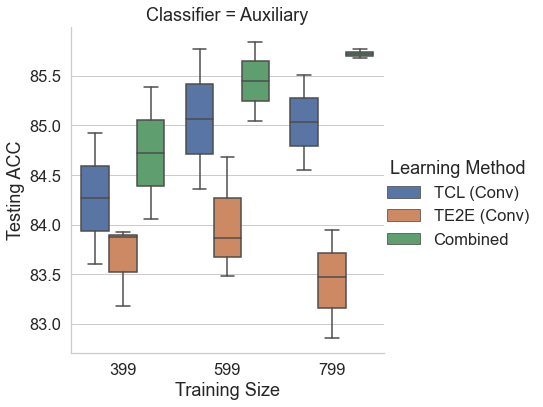

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.color_palette("hls")

sns.catplot(data=max_combined, x='Training Size', y='Testing ACC'
            , hue='Learning Method',col='Classifier', kind='box',
           height=6, aspect=1.0,)